# The problem

For images of $150\times 150$, we have a covariance matrix $\Sigma = 22500 \times 22500$. This is computationally expensive, as the matrix has $506,250,000$ entries. Our matrix is sampled from a normal distribution $\sim \mathcal{N}(0,\sigma^2)$ for $\sigma = \frac{5.4}{2\sqrt{2\log(2)}}$. This means that, given the entries we pass into the distribution (distances) are strictly positive, we can calculate confidences $\alpha$ such that:
$$\alpha = P_{\mathcal{N}(0,\sigma^2)}(d\leq\tau|d\geq 0),$$
$$P_{\mathcal{N}(0,\sigma^2)}(d\leq\tau|d\geq 0) = \frac{P_{\mathcal{N}(0,\sigma^2)}(0\leq d\leq \tau)}{P_{\mathcal{N}(0,\sigma^2)}(d\geq 0)}$$
The denominator is $\frac{1}{2}$ from basic properties of gaussian distributions, leaving us with the problem:

$$\alpha = 2P_{\mathcal{N}(0,\sigma^2)}(0\leq d\leq\tau) = 2(P_{\mathcal{N}(0,\sigma^2)}(d\leq\tau)-P_{\mathcal{N}(0,\sigma^2)}(d\leq 0))$$
These can be written in terms of the inverse CDF of the standard normal distribution under $\tau \rightarrow \frac{\tau}{\sigma}.$ Noting that the second term on the RHS is also $\frac{1}{2}$, the cutoff distance $\tau$ for a confidence $\alpha$ can be written as ($\Phi^{-1}$ is the inverse normal CDF):

$$\tau = \Phi^{-1}(\frac{1}{2}\alpha + \frac{1}{2})$$

Using this we can find some cutoffs of pixel distance $d_{ij}$ using this $\tau$. As we are working with $L_2$ norms, these distances directly translate as nighbourhoods of $n = \text{round}(\tau)$ from the diagonal of the large $\Sigma$. When this is translatd to $(\text{RA},\delta)$ norm, it will have to be handled with a direct mask

One way to do this is to set pixels outside of thee neighbourhood of $n$ to zero, this would be a banded diagonal matrix. This does however keep the extremely large dimensionality of $\Sigma$. Instead, it is proposed that the matrix uses an $n\times n$ cutout of the matrix, taken from $(0,0)$ to $(n,n)$, forming a matrix of blocks along the diagonal. This form of sparse matrix is called block diagonal and we formulate it as below.

## Terminology of the Block Diagonal Matrix.
The notation used for the formulation is "pythonic", using $\%$ to mean modulo division, $//$ to mean floor division. It is also set that $r=22500\; \% \;n$. Setting this allows for the handling of edge cases, as is seen later. $\Sigma_n$ is the matrix slice of size $n\times n$ as discussed above.

## Formulation of Block Diagonal Matrix
The matrix $\Sigma$ is reconstructed:

$$
\Sigma \approx \hat{\Sigma} = \begin{cases} \text{if r=0} & \text{diag}(\Sigma_n,...,\Sigma_n) \\ \text{otherwise} & \text{diag}(\Sigma_n,...,\Sigma_n,\Sigma_r)
\end{cases}

$$


The block diagonal has properties:
$$
\hat{\Sigma}^{-1} = \begin{cases} \text{if r=0} & \text{diag}(\Sigma_n^{-1},...,\Sigma_n^{-1}) \\ \text{otherwise} & \text{diag}(\Sigma_n^{-1},...,\Sigma_n^{-1},\Sigma_r^{-1})
\end{cases}
$$

$$
|\hat{\Sigma}| = \begin{cases} \text{if r=0} & \prod_{i=0}^{22500//2} |\Sigma_n| \\ \text{otherwise} & \left(\prod_{i=0}^{22500//2} |\Sigma_n|\right) + |\Sigma_r|
\end{cases}
$$

And therefore the log-determinant becomes:

$$
\log|\hat{\Sigma}| = \begin{cases} \text{if r=0} & \sum_{i=0}^{22500//2} \log |\Sigma_n| \\ \text{otherwise} & \left(\sum_{i=0}^{22500//2} \log|\Sigma_n|\right) + |\Sigma_r|
\end{cases}
$$


What matters most computationally in our case, as we consider the multivariate gaussian negative log likelihood, is the malahanobis term, or the term that has the matrix inversion:

$$
\frac{1}{2}(x-\mu)^T\Sigma^{-1} (x-\mu)
$$

With the above formulation, a simple algorithm to calculate it can be formed:

1. calculate $(x-\mu)$ as a vector.
2. Loop over i=0 to i= 22500//n-1:

    3. Find $z= (x-\mu)$[i*n:(i+1)*n].
    4. Compute $z^T \Sigma_n^{-1} z$.
    5. Add to Malahanobis distance and return to step 2.

6. If $r\neq 0$, $z_r = (x-\mu)[i*n:]$.
7. Add this to the malahanobis distance.

Thus, we now have a way to calculate each term in the negative log-likelihood.

## Importing and adding functions from other notebooks, previously used

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import cholesky, solve_triangular
from scipy.stats import norm
import pandas as pd
from IPython.display import display

In [2]:
image_size = 50 # image size in pixels
sigma = 5.4 / (2 * np.sqrt(2 * np.log(2))) # FWHM = 5.4

cmap = plt.cm.viridis.copy()  # Copy the viridis colormap
# Create a colormap where 0 is forced to white
cmap.set_bad(color='white')  # For masked values
cmap.set_under(color='white')  # For explicitly set zero values

In [3]:
def find_correlation_matrix(image_size,sigma):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    - Outputs:
        - Correlation matrix: the corrlation matrix as specified in the algorithm in the markdown cells above.
    """
    d = find_d(image_size)

    C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

    # Set the diagonal elements to 1
    np.fill_diagonal(C, 1)

    return C

def find_d(image_size):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    - Outputs:
        - Correlation matrix: the corrlation matrix as specified in the algorithm in the markdown cells above.
    """
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
    pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
    i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

    di = i[:, None] - i[None, :] 
    dj = j[:, None] - j[None, :] 
    d = 1.8*np.sqrt(di**2 + dj**2)
    return d

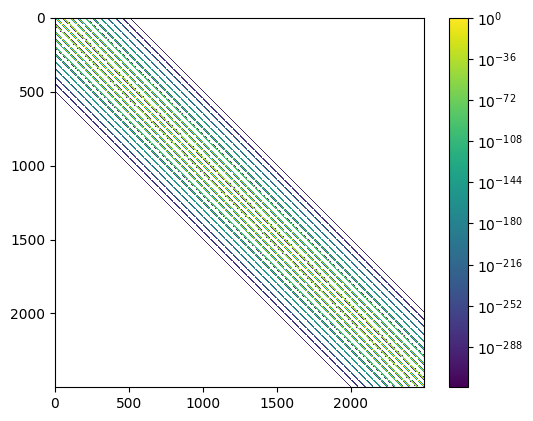

In [4]:
covariance_matrix = find_correlation_matrix(image_size,sigma)
# Plot the covariance matrix
plt.imshow(covariance_matrix, cmap=cmap, interpolation='nearest',norm=LogNorm())
plt.colorbar()
plt.show()

## Confidence Intervals

In [5]:
tau = lambda alpha: sigma*norm.ppf(0.5*alpha + 0.5)
C = lambda d: (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2))

alphas = np.array([0.95,0.997,0.9999,0.999999])
taus = tau(alphas)
n_values = np.ceil(taus).astype(int)
table_of_confidences = pd.DataFrame({'alpha':alphas,'confidence %': alphas*100,'tau':taus,'n':n_values, 'Correlation value at n':C(n_values)})
display(table_of_confidences)

,alpha,confidence %,tau,n,Correlation value at n
0,0.950000,95.0000,4.494528,5,1.614861e-02
1,0.997000,99.7000,6.805524,7,1.648504e-03
2,0.999900,99.9900,8.921784,9,7.864956e-05
3,0.999999,99.9999,11.217353,12,1.968804e-07


In [6]:
get_block = lambda cov,n: cov[:n,:n]
cov_5 = get_block(covariance_matrix,n_values[0])
cov_7 = get_block(covariance_matrix,n_values[1])
cov_9 = get_block(covariance_matrix,n_values[2])
cov_12 = get_block(covariance_matrix,n_values[3])

## Calculating the Negative-Log-Likelihood

In practise, what `pytorch` does is avoid matrix inversion through Cholesky decomposition. This takes an SPD matrix, and breaks it down into two triangular matrices $\Sigma_n = LL^T$. This allows to use properties of these triangular matrices, called `solve_triangular`, to solve the system $y=L(x-\mu)$ this method is approximated through the use of SciPy to do the equivalent method for this, and then the full malahonobis term becomes $\frac{1}{2}y^Ty$

In [7]:
def block_diagonal_mvg_NLL(cov,x,mu,n,batch_size=1):
    """
    Calculates the multivariate gaussian neg-log-likelihood for a block diagonal approximation of the matrix.
    inputs:
        - cov: the covariance matrix
        - x: the data flattened
        - mu: the mean flattened
        - n: the block size
    returns:
        - the negative log-likelihood
    """
    num_blocks = len(x) // n
    remainder_size = len(x) % n

    B = cov[:n,:n] # Get the block
    L = cholesky(B, lower=True) # Cholesky decomposition
    logdet = 2*np.sum(np.log(np.diag(L))) # Log determinant

    z = x-mu
    malahanobis = 0
    for i in range(num_blocks):
        zi = z[i*n:(i+1)*n]
        yi = solve_triangular(L,zi,lower=True)
        malahanobis += np.dot(yi,yi)
    if remainder_size > 0:
        B_rem = cov[:remainder_size,:remainder_size] # Take the same assumption for the remainder size
        L_rem = cholesky(B_rem, lower=True)
        zi = z[num_blocks*n:]
        yi = solve_triangular(L_rem,zi,lower=True)
        malahanobis += np.dot(yi,yi)
        logdet += 2*np.sum(np.log(np.diag(L_rem)))

    return 0.5*(logdet + malahanobis + len(x)*batch_size*np.log(2*np.pi))


def negative_log_likelihood_cholesky(x, mu, cov):
    """
    Calculates the multivariate gaussian neg-log-likelihood for the matrix.
    inputs:
        - cov: the covariance matrix
        - x: the data flattened
        - mu: the mean flattened
        - n: the block size
    returns:
        - the negative log-likelihood
    """
    L = cholesky(cov, lower=True)
    y = solve_triangular(L, x - mu, lower=True)
    
    quad_term = np.dot(y, y)
    log_det = 2 * np.sum(np.log(np.diag(L)))
    

    n = len(x)
    nll = 0.5 * (log_det + quad_term + n * np.log(2 * np.pi))
    return nll
    

In [8]:
x = np.random.randn(image_size**2)
mu = np.random.randn(image_size**2)

In [9]:
NLL_tradiational = negative_log_likelihood_cholesky(x, mu, covariance_matrix)
NLL_list = np.array([block_diagonal_mvg_NLL(covariance_matrix,x,mu,n_values[0]),
                     block_diagonal_mvg_NLL(covariance_matrix,x,mu,n_values[1]),
                     block_diagonal_mvg_NLL(covariance_matrix,x,mu,n_values[2]),
                     block_diagonal_mvg_NLL(covariance_matrix,x,mu,n_values[3])])

In [10]:
table_of_NLL = pd.DataFrame({
    'Traditional': NLL_tradiational,
    'n=5': NLL_list[0],
    'n=7': NLL_list[1],
    'n=9': NLL_list[2],
    'n=12': NLL_list[3]
}, index=['NLL'])

ratio_row = table_of_NLL.loc['NLL'] / table_of_NLL.loc['NLL', 'Traditional']
loss_row = (1 - table_of_NLL.loc['NLL'] / table_of_NLL.loc['NLL', 'Traditional'])*100
table_of_NLL.loc['Ratio'] = ratio_row
table_of_NLL.loc['% of loss lost'] = loss_row

display(table_of_NLL)

,Traditional,n=5,n=7,n=9,n=12
NLL,4894.558491,4842.914899,4862.011030,4857.084435,4859.179596
Ratio,1.000000,0.989449,0.993350,0.992344,0.992772
% of loss lost,0.000000,1.055123,0.664972,0.765627,0.722821


In [11]:
%%timeit
negative_log_likelihood_cholesky(x, mu, covariance_matrix)

244 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
block_diagonal_mvg_NLL(covariance_matrix,x,mu,n_values[0])

5.01 ms ± 139 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is a very large time saving for this method, analytically, we are comparing $22500^2$ entries with, $n=12$, giving $12^2 \times 22500//2 =1620000$, giving a ratio of 312.5 if every entry is considered. This is not necessarily the case for Cholesky decomposition, which gives us the discrepancy.

In [13]:
nll_to_matrix = lambda cov, x, mu, n_values: np.column_stack((
    n_values,
    np.array([block_diagonal_mvg_NLL(cov, x, mu, n) for n in n_values])
))

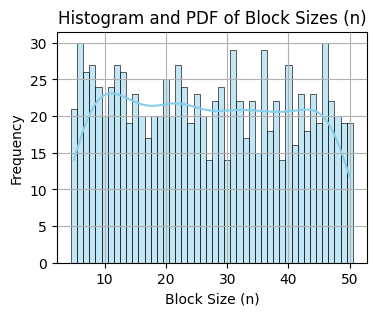

In [14]:
n_values = np.random.randint(5, 51, size=1000)

plt.figure(figsize=(4, 3))
sns.histplot(n_values, bins=np.arange(4.5, 51.5, 1), kde=True, color='skyblue', edgecolor='black')
plt.title('Histogram and PDF of Block Sizes (n)')
plt.xlabel('Block Size (n)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [15]:
nll_matrix = nll_to_matrix(covariance_matrix, x, mu, n_values)
df = pd.DataFrame(nll_matrix, columns=['n', 'NLL'])

2 minutes 22.5 seconds to calculate 100,000 log likelihoods

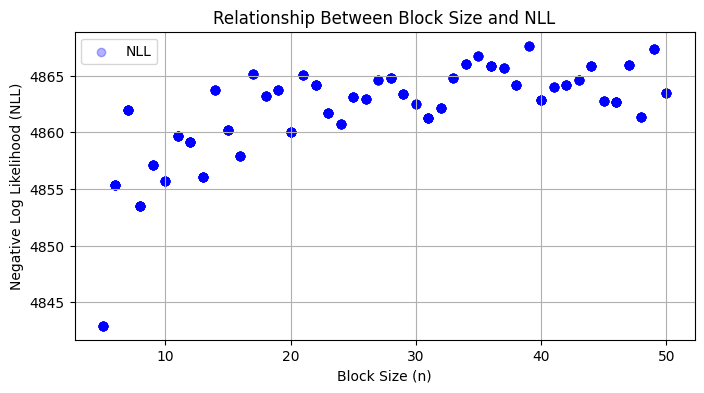

In [16]:
plt.figure(figsize=(8, 4))
plt.scatter(data=df, x='n', y='NLL', alpha=0.3, color='blue')
plt.title('Relationship Between Block Size and NLL')
plt.xlabel('Block Size (n)')
plt.ylabel('Negative Log Likelihood (NLL)')
plt.grid(True)
plt.legend()
plt.show()


## Moving to $(RA,\delta)$


The point-spread function is given to have three forms depending no $\delta$ (found here)[https://sundog.stsci.edu/first/catalogs/readme.html].
1. In the north, the beam is circular 5.4 arcsec FWHM.
2. south of $\delta = +4°33'21"$, the beam is elliptical, 6.4x5.4 arcsec FWHM.
3. In RA = 21hrs to 3hrs and  6.8x5.4 arcsec south of $\delta -2°30'25"$

(1.) is the circular assumption used previously, (2. & 3.) are sampling from multivariate gaussians. To fully incorporate all of these, block diagonal formulations will be necessary, the computational space needed to store all three of these too high. Either way, this method requires moving to the (RA,$\delta$) norm. The FWHM are given as MajxMin, denoting directions of the ellipse. In the beam's own frame of reference this matrix is diagonal 
$$
\Sigma_{psf} = 
\begin{pmatrix}
\sigma^2_{maj} & 0\\
0 & \sigma^2_{min}
\end{pmatrix}.
$$

Previously, we were sampling from a univariate gaussian, $\sim \mathcal{N}(0,\sigma^2)$, now we are sampling $\sim \mathcal{N}(0,\Sigma_{psf})$, and the pixel-distance was calculated by using the $L_2$ norm. Now, we have a different coordinate system and should change the method we use to calculate distances and therefore sample the distribution. We know each pixel $(i,j)$ is $(\Delta\alpha,\Delta\delta) = (1.8",1.8")$ in size on the sky. For a pixel $x = (\alpha_i,\delta_j)$, it has distance to a pixel $x = (\alpha_k,\delta_l)$

$$
d_{RA}(x,y) = (\alpha_i - \alpha_k)\cos(\delta_j) = 1.8"(i-k)\cos(\delta_j)
$$

$$
d_{\delta}(x,y) = (\delta_j - \delta_l) = 1.8"(j-l)
$$

Where these two will serve as the arguments for the normal distribution, and C is populated as 
$$
C(x,y) = P_{\mathcal{N}(0,\Sigma_{psf})}(d_{RA}(x,y),d_{\delta}(x,y)) = \exp{\left(-\frac{1}{2}\mathbf{d}^T\Sigma^{-1}\mathbf{d}\right)}
$$



In [22]:
import astropy.units as u

def find_covariance_matrix(image_size, fwhm_major, fwhm_minor, pixel_scale=1.8):

    # The below is identical to the formulation in previous notebooks
    sigma_major = (fwhm_major / 2 * np.sqrt(2 * np.log(2))) * u.arcsec
    sigma_minor = (fwhm_minor / 2 * np.sqrt(2 * np.log(2))) * u.arcsec
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")

    # Only difference is imposing the angular size of (1.8",1.8")
    ra = x * pixel_scale * u.arcsec  
    dec = y * pixel_scale * u.arcsec  

    ra_flat = ra.ravel()
    dec_flat = dec.ravel()

    d_ra = (ra_flat[:, None] - ra_flat[None, :]) * np.cos(dec_flat[:, None].to_value(u.rad))  # RA differences are calculated with cos(\delta_j)
    d_dec = (dec_flat[:, None] - dec_flat[None, :])  # Declination differences 

    # "Invert the covariance matrix", in our case it is diagonal, so invert just the elements
    sigma_x_inv_sq = (1 / sigma_major.to_value(u.arcsec)) ** 2
    sigma_y_inv_sq = (1 / sigma_minor.to_value(u.arcsec)) ** 2 

    # The gaussian we sample from
    exponent = -0.5 * (d_ra ** 2 * sigma_x_inv_sq + d_dec ** 2 * sigma_y_inv_sq)
    # impose dimension-less-ness
    exponent = exponent.value

    C = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(exponent)

    # Set diagonal elements to 1 (self-correlation)
    np.fill_diagonal(C, 1.0)

    return C


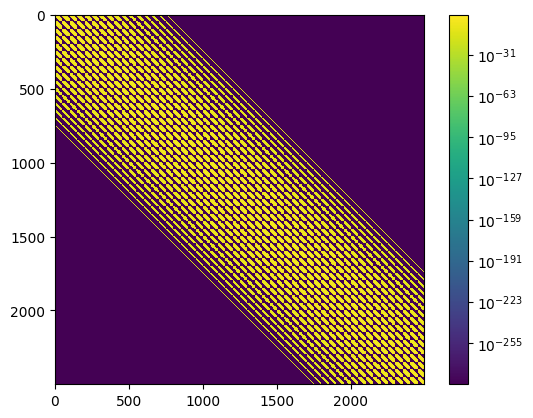

In [23]:
cov = find_covariance_matrix(image_size,5.4,6.4)
# Plot the covariance matrix
plt.imshow(cov, cmap=cmap, interpolation='nearest',norm=LogNorm())
plt.colorbar()
plt.show()

In [19]:
np.where(cov<0)

(array([], dtype=int64), array([], dtype=int64))

In [20]:
symmetric = lambda a: np.allclose(a, a.T, rtol=1e-05, atol=1e-08)

symmetric(cov)

True

To construct the block diagonal, we have to consider the fact we will have two cutoffs $\tau_x,\tau_y$ instead of one. Otherwise, the problem continues as in the univariate case, and we have:
$$
\frac{1}{2}\alpha = P_{\mathcal{N}(0,\Sigma)}(0\leq \mathbf{d}\leq\vec{\tau})
$$
calling the two directions $x,y$, we are left with:

$$\frac{1}{2}\alpha = P(0\leq x\leq \tau_x, 0 \leq y\leq\tau_y)$$
For some $\alpha$, this problem can be broken down by considering the $\mathbb{R}^2$ space that our variables live in

<div style="text-align: center;">
    <img src="copy.png" width="500">
</div>


What we have now, is a way to express the above in terms of cumulates:

$$
\frac{1}{2}\alpha = \Phi\left(\frac{{\tau_x}}{{\sigma_x}},\frac{{\tau_y}}{{\sigma_y}}\right) - \Phi\left(\frac{{\tau_x}}{{\sigma_x}},0\right)- \Phi\left(0,\frac{{\tau_y}}{{\sigma_y}}\right) + \Phi(0,0)
$$

Where we have introduced the standard multivariate normal CDF $\Phi$, and standardised $\tau_i$ by dividing by the standard deviation where appropriate.

Noticing $\Phi(0,0)=\frac{1}{2}$ and therefore writing $\tilde{\alpha} = \frac{1}{2}(\alpha-1)$. We can also write the standardised variables used for $\frac{\tau_i}{\sigma_i}\equiv \tilde{\tau_i}$. The standard multivariate normal cumulative distribution function $\Phi(x,y)$ is given by:

$$
\Phi(x,y) = \frac{1}{2\pi}\int_{-\infty}^xdx'\int_{-\infty}^ydy' \exp{\left(-\frac{1}{2}(x'^2+y'^2)\right)}
$$

So in our case:


$$
\Phi(\tau_x,\tau_y) = \frac{1}{2\pi}\int_{-\infty}^{\tilde{\tau_x}}dx\int_{-\infty}^{\tilde{\tau_y}}dy \exp{\left(-\frac{1}{2}(x^2+y^2)\right)}
$$
$$
= \frac{1}{2\pi}\left[
\sqrt{\frac{\pi}{2}} + \int_0^{\tilde{\tau_x}} \exp{\left(-\frac{1}{2}x^2\right)}dx
\right]\left[
\sqrt{\frac{\pi}{2}} + \int_0^{\tilde{\tau_y}} \exp{\left(-\frac{1}{2}y^2\right)}dy
\right].
$$
Changing variables $\tilde{x},\tilde{y}=\frac{1}{\sqrt{2}}x,y$, the integrals can be written as:
$$
\int_0^{\frac{\tau_y}{\sqrt{2}}(\equiv \bar{\tau_y})}\exp{(-\tilde{y}^2)}d\tilde{y}
$$

Which allows us to use the gaussian error function $\text{erf}(z) = \int_0^{z}e^{-t^2}dt$. Using this, noting the $\bar{\tau_y}=\tilde{\tau_y}/\sqrt{2}$
$$
\Phi(\tilde{\tau_x},\tilde{\tau_y}) = \frac{1}{2(2\pi)^{\frac{1}{2}}}(1+\text{erf}(\bar{\tau_x}))(1+\text{erf}(\bar{\tau_y}))
$$
Using the same method, you achieve the form for both of the other CDFs:
$$
\Phi(\tilde{\tau_x},0) = \frac{\pi}{2}(1+\text{erf}(\bar{\tau_x}))
$$
$$
\Phi(0,\tilde{\tau_y}) = \frac{\pi}{2}(1+\text{erf}(\bar{\tau_y}))
$$

So the probability is given by, writing $C = \frac{1}{2\sqrt{2\pi}}-\frac{\pi}{2}$
$$
\frac{1}{2}(\alpha-1) = C + C\text{erf}(\frac{\tau_x}{\sigma_x\sqrt{2}})+ C\text{erf}(\frac{\tau_y}{\sigma_y\sqrt{2}}) + \left(C+\frac{\pi}{2}\right)\text{erf}(\frac{\tau_y}{\sigma_y\sqrt{2}})\text{erf}(\frac{\tau_x}{\sigma_x\sqrt{2}})
$$

In [21]:
import numpy as np #imported here to avoid running the full notebook again
from scipy.optimize import fmin
from scipy.special import erf

alpha = 0.95
sigma_x = 5.4/(2*np.sqrt(2*np.log(2)))
sigma_y = 6.4/(2*np.sqrt(2*np.log(2)))
C = 1/(2*np.sqrt(2*np.pi))

def equation_error(tau):
    tau_x, tau_y = tau

    erf_x = erf(tau_x / (sigma_x * np.sqrt(2)))
    erf_y = erf(tau_y / (sigma_y * np.sqrt(2)))

    lhs = 0.5 * (alpha - 1)
    rhs = (
        C
        + C * erf_x
        + C * erf_y
        + (C + np.pi / 2) * erf_x * erf_y
    )

    error = (lhs - rhs) ** 2
    return error

initial_guess = [500, 20]

result = fmin(equation_error, initial_guess, disp=True)

tau_x, tau_y = result
print(f"Optimized tau_x: {tau_x}")
print(f"Optimized tau_y: {tau_y}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 114
         Function evaluations: 231
Optimized tau_x: 759.2781695328717
Optimized tau_y: -0.7422535626297444


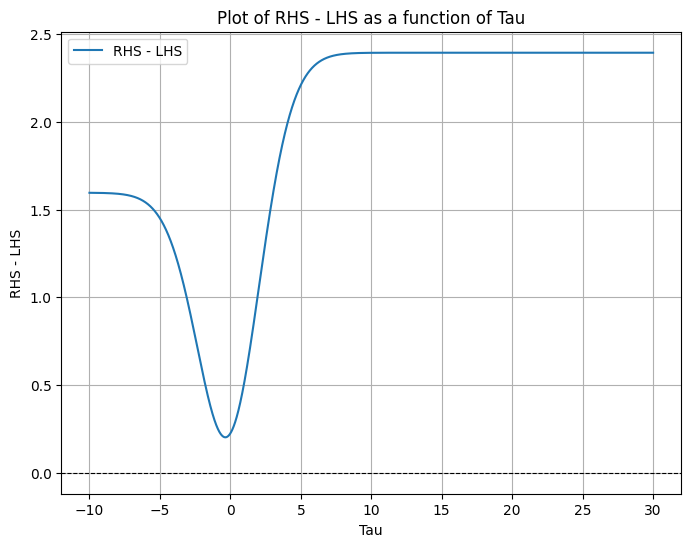

In [14]:
import matplotlib.pyplot as plt
def rhs_lhs_function(tau):
    erf_x = erf(tau / (sigma_x * np.sqrt(2)))
    erf_y = erf(tau / (sigma_y * np.sqrt(2)))
    lhs = 0.5 * (alpha - 1)
    rhs = (
        C
        + C * erf_x
        + C * erf_y
        + (C + np.pi / 2) * erf_x * erf_y
    )
    return rhs - lhs

# Plot the function
tau_values = np.linspace(-10, 30, 10000)
rhs_lhs_values = [rhs_lhs_function(tau) for tau in tau_values]

plt.figure(figsize=(8, 6))
plt.plot(tau_values, rhs_lhs_values, label="RHS - LHS")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Tau")
plt.ylabel("RHS - LHS")
plt.title("Plot of RHS - LHS as a function of Tau")
plt.legend()
plt.grid()
plt.show()

Alternatively, one could look directly at:
$$
\frac{1}{2}\alpha = P_{\mathcal{N}(0,\Sigma)}(0\leq \mathbf{d}\leq\vec{\tau})
$$

$$
\frac{1}{2}\alpha = P_{\mathcal{N}(0,\hat{I})}(0\leq \mathbf{d}\leq\vec{\frac{\tau}{\sigma}})
$$

which gives the solution:

$$
\frac{1}{2}\alpha = \frac{\pi}{2} \text{erf}\left(\frac{\tau_x}{\sigma_x\sqrt{2}}\right) \text{erf}\left(\frac{\tau_y}{\sigma_y\sqrt{2}}\right)
$$

In [17]:
def equation_error(tau):
    erf_x = erf(tau / (sigma_x * np.sqrt(2)))
    erf_y = erf(tau / (sigma_y * np.sqrt(2)))

    lhs = 0.5 * alpha
    rhs = (
        np.pi / 2 * (erf_x * erf_y)
    )

    error = (lhs - rhs) ** 2
    return error

initial_guess = [20]  # Single tau value

result = fmin(equation_error, initial_guess, disp=True)

tau = result[0]
print(f"Optimized tau: {tau}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 45
Optimized tau: -1.88818359375


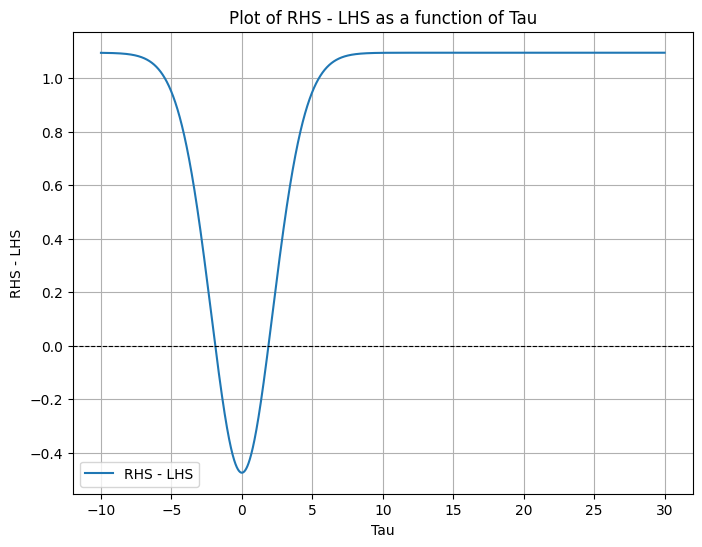

In [15]:
import matplotlib.pyplot as plt
def rhs_lhs_function(tau):
    erf_x = erf(tau / (sigma_x * np.sqrt(2)))
    erf_y = erf(tau / (sigma_y * np.sqrt(2)))

    lhs = 0.5 * (alpha)
    rhs = (
        np.pi/2 * (erf_x * erf_y)
    )
    return rhs - lhs

# Plot the function
tau_values = np.linspace(-10, 30, 10000)
rhs_lhs_values = [rhs_lhs_function(tau) for tau in tau_values]

plt.figure(figsize=(8, 6))
plt.plot(tau_values, rhs_lhs_values, label="RHS - LHS")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Tau")
plt.ylabel("RHS - LHS")
plt.title("Plot of RHS - LHS as a function of Tau")
plt.legend()
plt.grid()
plt.show()

Unfortunately, these functions don't have useful roots for a cutoff to define the square matrix